<a href="https://colab.research.google.com/github/dev0419/Pytorch_FreeCodeCamp/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import torch
from torch import nn
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import tqdm
print(f"Pytorch version : {torch.__version__} Torchvision:{torchvision.__version__}")

Pytorch version : 2.1.0+cu121 Torchvision:0.16.0+cu121


In [23]:
from torchvision import datasets
train = datasets.FashionMNIST(root='./data',train=True,download=True,transform=ToTensor(),target_transform=None)
test = datasets.FashionMNIST(root='./data',train=False,download=True,transform=ToTensor())

In [24]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(
    train,batch_size=BATCH_SIZE,shuffle=True
)
test_dataloader = DataLoader(
    test,batch_size=BATCH_SIZE,shuffle=False
)

print(f"Dataloader: {train_dataloader, test_dataloader}")
print(f"Length of a train dataloader:  {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of a test dataloader:  {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloader: (<torch.utils.data.dataloader.DataLoader object at 0x794b921dba00>, <torch.utils.data.dataloader.DataLoader object at 0x794b921da800>)
Length of a train dataloader:  1875 batches of 32
Length of a test dataloader:  313 batches of 32


In [25]:
train_features_batch,train_labels_batch = next(iter(train_dataloader))
test_features_batch,test_labels_batch = next(iter(test_dataloader))

Image size: torch.Size([1, 1, 28, 28])
Label: tensor([1]), label size: torch.Size([1])


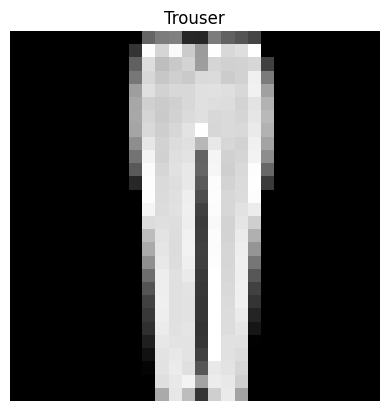

In [26]:
torch.manual_seed(42)
rand_idx = torch.randint(0,len(train_features_batch),size=[1])
img,label = train_features_batch[rand_idx],train_labels_batch[rand_idx]
plt.imshow(img.squeeze(), cmap="gray")
class_names = train.classes
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [27]:
# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

# Try uncommenting below and see what happens
#print(x)
#print(output)

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [28]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [29]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)



In [30]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [32]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self,input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.blk1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
            out_channels = hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.blk2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.clf = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self,x):
        x = self.blk1(x)
        x = self.blk2(x)
        x = self.clf(x)
        return x

torch.manual_seed(42)
model = FashionMNISTModelV2(input_shape=1,hidden_units=10,output_shape=len(class_names)).to(device)
model


FashionMNISTModelV2(
  (blk1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (blk2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clf): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [33]:
loss_fn  = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.1)

In [34]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss,train_acc = 0,0
    model.to(device)
    for i,(X,y) in enumerate(train_dataloader):
        X,y =  X.to(device),y.to(device)
        y_prd = model(X)
        loss = loss_fn(y_prd,y)
        train_loss += loss
        train_acc += accuracy_fn(y,y_prd.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss,test_acc = 0,0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device),y.to(device)
            test_prd = model(X)
            test_loss += loss_fn(test_prd,y)
            test_acc += accuracy_fn(y,test_prd.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")


In [35]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    loss,acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device),y.to(device)
            y_prd = model(X)
            loss += loss_fn(y_prd,y)
            acc += accuracy_fn(y,y_prd)
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [36]:
torch.manual_seed(42)

# Measure time
from tqdm import tqdm
from timeit import default_timer as timer
train_time_start_model = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model = timer()
total_train_time_model = print_train_time(start=train_time_start_model,
                                           end=train_time_end_model,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59248 | Train accuracy: 78.39%


 33%|███▎      | 1/3 [00:11<00:23, 11.79s/it]

Test loss: 0.39531 | Test accuracy: 86.20%
Epoch: 1
---------
Train loss: 0.35403 | Train accuracy: 87.44%


 67%|██████▋   | 2/3 [00:23<00:11, 11.70s/it]

Test loss: 0.34034 | Test accuracy: 87.65%
Epoch: 2
---------
Train loss: 0.31512 | Train accuracy: 88.66%


100%|██████████| 3/3 [00:35<00:00, 11.73s/it]

Test loss: 0.32143 | Test accuracy: 88.60%
Train time on cuda: 35.204 seconds


In [37]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [42]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample,dim=0)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [39]:
pred_probs = make_predictions(model,test_samples)
pred_probs[:2]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)